In [7]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset

# Load the dataset (index-only loading)
print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/rc2_norm')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")

# Create PyTorch dataset (should load only labels)
print("\nCreating PyTorch dataset (loads only labels)...")
t1 = time.time()
datasets = PytorchDataset.create_splits(dataset, random_state=42)
print(f"split created in {time.time() - t1:.2f} seconds")

# Access label of first sample (fast, from preloaded label column)
print("\ncreating val...")
t2 = time.time()
val_dataset = datasets['val'] 
print(f"Val label: {val_dataset} (retrieved in {time.time() - t2:.4f} seconds)")

# Access label of first sample (fast, from preloaded label column)
print("\ncreating val...")
t3 = time.time()
test_dataset = datasets['test'] 
print(f"test label: {test_dataset} (retrieved in {time.time() - t3:.4f} seconds)")

print("\ncreating train...")
t3 = time.time()
train_dataset = datasets['train'] 
print(f"train label: {train_dataset} (retrieved in {time.time() - t3:.4f} seconds)")

Loading dataset...
Loaded inference registry from /sps/lsst/groups/transients/HSC/fouchez/raphael/data/rc2_norm/inference/inference_registry.json
Dataset loaded in 0.01 seconds

Creating PyTorch dataset (loads only labels)...
Building sample index...
Creating splits from 57905 samples...
Loading 40533 cutouts...
Loading 5791 cutouts...
Loading 11581 cutouts...
split created in 11.89 seconds

creating val...
Val label: PytorchDataset(5791 samples)
  Image shape: (5791, 30, 30)
  Labels: 1312 injected, 4479 real (retrieved in 0.0004 seconds)

creating val...
test label: PytorchDataset(11581 samples)
  Image shape: (11581, 30, 30)
  Labels: 2624 injected, 8957 real (retrieved in 0.0003 seconds)

creating train...
train label: PytorchDataset(40533 samples)
  Image shape: (40533, 30, 30)
  Labels: 9182 injected, 31351 real (retrieved in 0.0024 seconds)


Loading cutouts from visit 322
Visualizing cutouts for IDs: [138385993760770 138385993760771 138385993760772 138385993760773
 138385993760774 138385993760775]


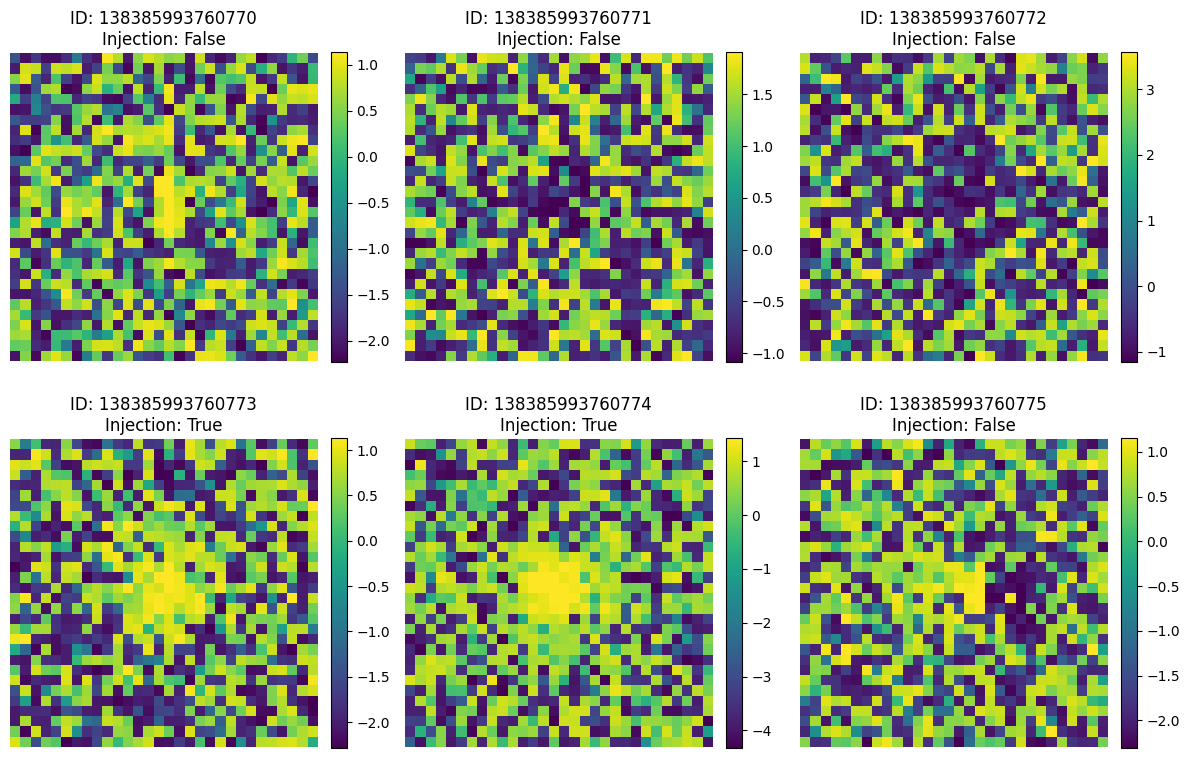

Cutout shape: (30, 30)
Cutout data type: float64
Cutout value range: [-2.309, 1.151]


In [8]:
# Visualize some cutouts
import matplotlib.pyplot as plt
import numpy as np

# Get a few sample IDs from the first visit
first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

# Get the cutout loader for the first visit
cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]

# Get first 6 IDs
sample_ids = cutout_loader.ids[:6]
print(f"Visualizing cutouts for IDs: {sample_ids}")

# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    # Get cutout and label
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    # Display cutout (assuming it's a 2D array)
    # If cutout has multiple channels, you might need cutout[:,:,0] or similar
    im = axes[i].imshow(cutout, cmap='viridis', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Cutout data type: {cutout.dtype}")
print(f"Cutout value range: [{cutout.min():.3f}, {cutout.max():.3f}]")